## Final Project Submission

Please fill out:
* Student name: Devin Belden
* Student pace: full time
* Scheduled project review date/time: Tue, Oct 29, 2019, 3:30 PM - 4:15 PM
* Instructor name: James Irving, Ph.D
* Blog post URL: Unknown

# Business Case

The purpose of this technical notebook is to explore the housing market in King County, Washington, so as to provide a healthy amount of information to prospective investors before or after they've invested in a property in the area. In short, the goal is to answer the question: "What features of a property can be manipulated such that the selling price is increased, and the investor's profit is maximized?" 

## Obtaining/Exploring Data
* As always, we must import packages before loading in the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
%matplotlib inline
inline_rc = dict(mpl.rcParams)

plt.style.use('seaborn')

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest as normtest # D'Agostino and Pearson's omnibus test

from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

C:\Users\Devin\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  import sys


In [2]:
df = pd.read_csv('kc_house_data.csv')
display(df.head())
display(df.info())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


None

In [3]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [4]:
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2350.0        1
4130.0        1
1525.0        1
2300.0        1
1481.0        1
Name: sqft_basement, Length: 304, dtype: int64

## Data Cleaning
* There are nan's and '?' placeholders in certain columns
* We'll transform yr_renovated into a categorical column while we're at it

In [5]:
df_temp = df.copy()
df_temp['yr_renovated'].fillna(0, inplace=True)
df_temp['is_renovated'] = df_temp['yr_renovated'].map(lambda x: x!=0)
df_temp['waterfront'].fillna(0, inplace=True)
df_temp['waterfront'] = df_temp['waterfront'].astype(int)
df_temp['view'].fillna(0., inplace=True)
df_temp['view'] = df_temp['view'].astype(int)
df_temp.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
is_renovated     0
dtype: int64

### Next we'll drop some columns that will clearly not help us in our search for price factors 
* We'll drop 'date' and 'id', as well as 'yr_renovated' due to our transform in the previous cell
* We'll drop 'sqft_basement' due to the high amount of placeholders. Additionally, 'sqft_basement' is just 'sqft_living' - 'sqft_above', so they're very highly correlated

In [6]:
df_temp.drop(['date','id','yr_renovated','sqft_basement'], axis=1, inplace=True)

### Let's remove some known outliers. 
* The vast majority (>95%) of the data sold for less than $1.17M and has fewer than 8 bedrooms

In [7]:
df_temp = df_temp[df_temp['price'] <= 1170000]
df_temp = df_temp[df_temp['bedrooms'] < 8].reset_index()
df_temp.drop(['index'], axis=1, inplace=True)

Let's make sure we didn't delete too much data.

In [8]:
display(df_temp.head())
len(df_temp)/len(df)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,1955,98178,47.5112,-122.257,1340,5650,False
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,1951,98125,47.7210,-122.319,1690,7639,True
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,1933,98028,47.7379,-122.233,2720,8062,False
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,1965,98136,47.5208,-122.393,1360,5000,False
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,1987,98074,47.6168,-122.045,1800,7503,False


0.9503634764087605

We deleted less than 5% of our total data. Not bad! Let's check again for nan's

In [9]:
df_temp.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
is_renovated     0
dtype: int64

### Next, let's locate categorical variables

In [10]:
df_temp.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.052500e+04,20525.000000,20525.000000,20525.000000,2.052500e+04,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000
mean,4.799598e+05,3.329354,2.055530,1982.328234,1.466668e+04,1.476906,0.002680,0.175493,3.406772,7.540999,1714.063727,1970.855542,98078.486918,47.557096,-122.213107,1927.918831,12469.191328
std,2.126331e+05,0.873324,0.711512,783.170129,4.016837e+04,0.536708,0.051697,0.647841,0.647125,1.046212,734.612284,29.160295,53.346286,0.140862,0.142287,621.067891,26534.467170
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.150000e+05,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1180.000000,1951.000000,98033.000000,47.461100,-122.330000,1470.000000,5060.000000
50%,4.390000e+05,3.000000,2.000000,1860.000000,7.504000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1520.000000,1974.000000,98065.000000,47.567100,-122.231000,1800.000000,7560.000000
75%,6.050000e+05,4.000000,2.500000,2440.000000,1.035000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2110.000000,1996.000000,98118.000000,47.679700,-122.122000,2280.000000,9900.000000
max,1.170000e+06,7.000000,6.750000,7480.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,12.000000,7320.000000,2015.000000,98199.000000,47.777600,-121.315000,5380.000000,871200.000000


We have some categorical variables for sure. Just by eyeballing it, 'waterfront', 'view', condition', 'grade', 'is_renovated', and 'zipcode' could all be categorical. 

In [11]:
df_temp[['waterfront', 'view', 'condition', 'grade', 'is_renovated', 'zipcode']].nunique()

waterfront       2
view             5
condition        5
grade           10
is_renovated     2
zipcode         70
dtype: int64

We can one-hot encode these in one step when creating the initial model, but let's create a list anyway. It might come in handy later on.

In [12]:
one_hot_columns = ['waterfront','view','condition','grade','is_renovated','zipcode']

### Checking for multicollinearity

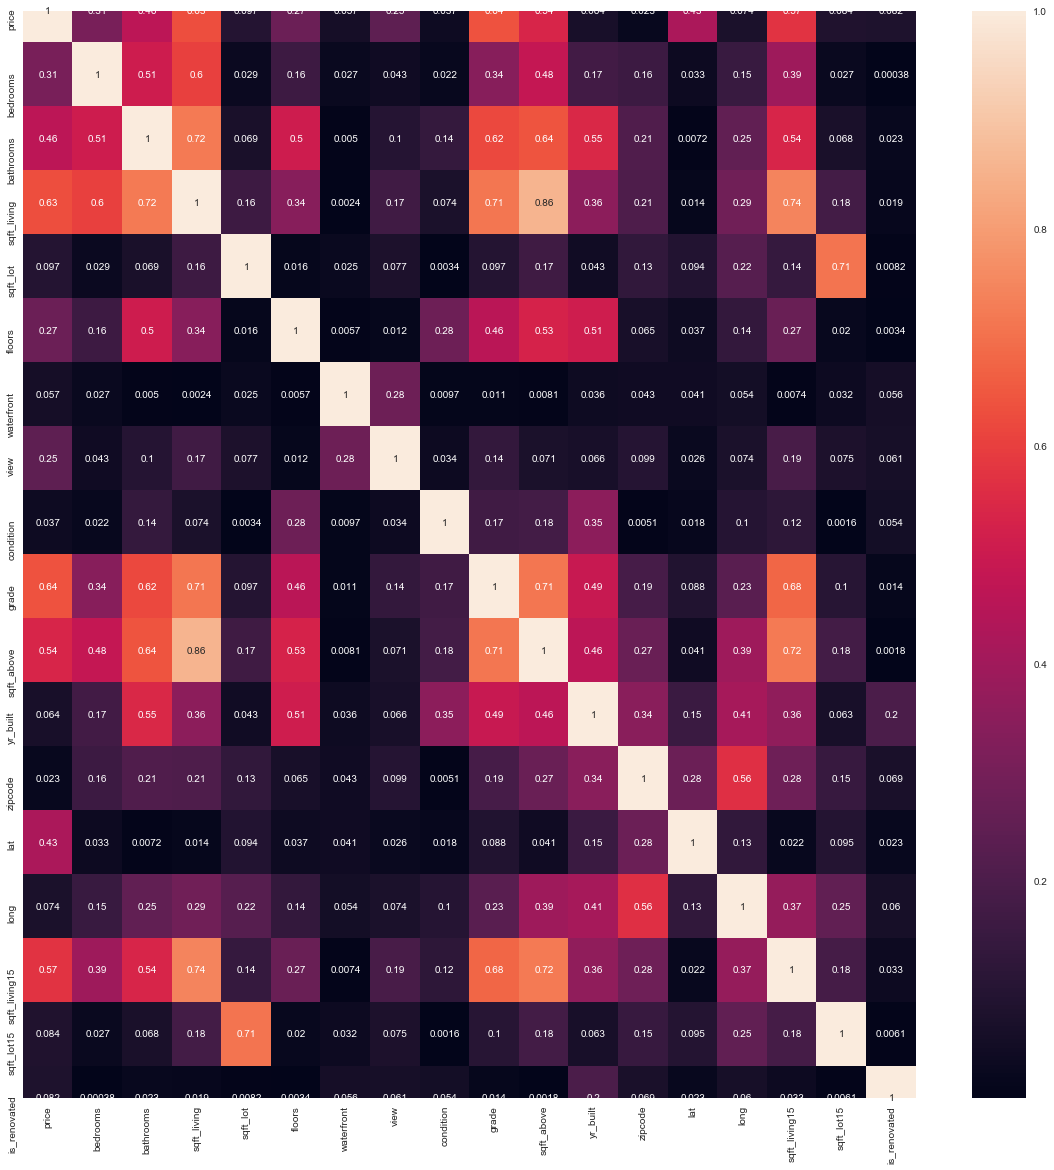

In [13]:
plt.figure(figsize=(20,20))
sns.heatmap(abs(df_temp.corr()), annot=True);

It looks like sqft_above is unacceptably highly correlated (>0.75) with sqft_living, which makes sense. We will drop 'sqft_above' as we've already dropped 'sqft_basement', and 'sqft_living' gives more information. In hindsight, we could have dropped this column when dropping 'sqft_basement', but then we wouldn't have this pretty graph!

In [14]:
df_temp.drop(['sqft_above'], axis=1, inplace=True)

### Transforming features

Let's check the distribution of the variables to see what's normally distributed and what isn't. Anything not normally distributed will be log transformed. After the log transform, every variable will be scaled, whether the transformation worked or not. 

nb: we don't need the one-hot columns, as those will be transformed differently.

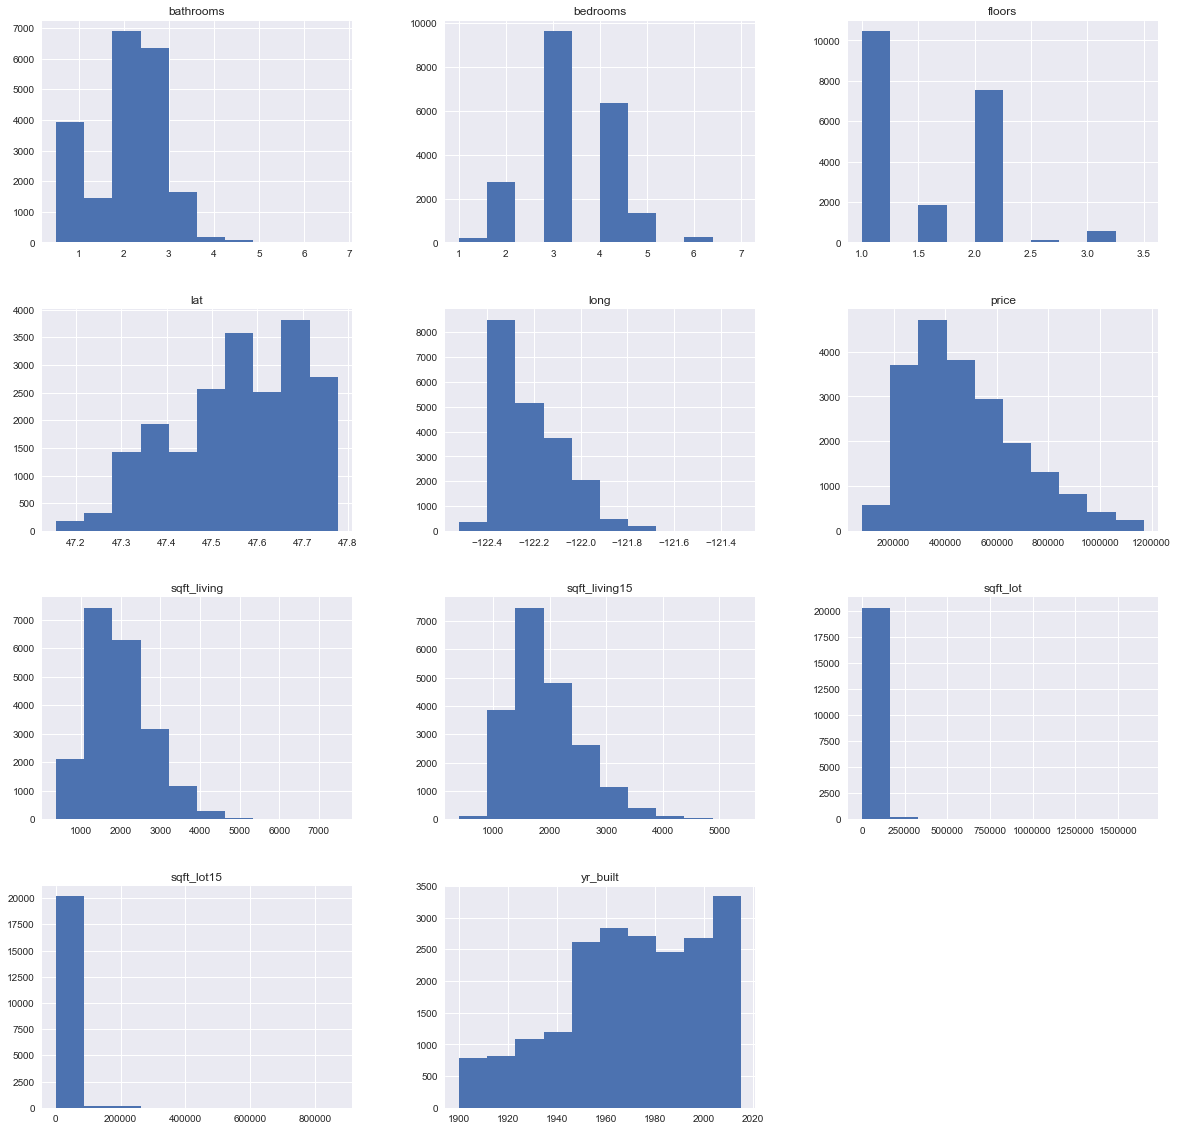

In [15]:
df_temp.drop(one_hot_columns, axis=1).hist(figsize=(20,20));

Looks like almost everything has a positive skew. We'll log transform 'bathrooms', 'floors', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', and 'yr_built'.

Note: The reason we're not transforming 'price' is because it's our target variable. Again, in hindsight, we should have temporarily dropped it from this dataframe.

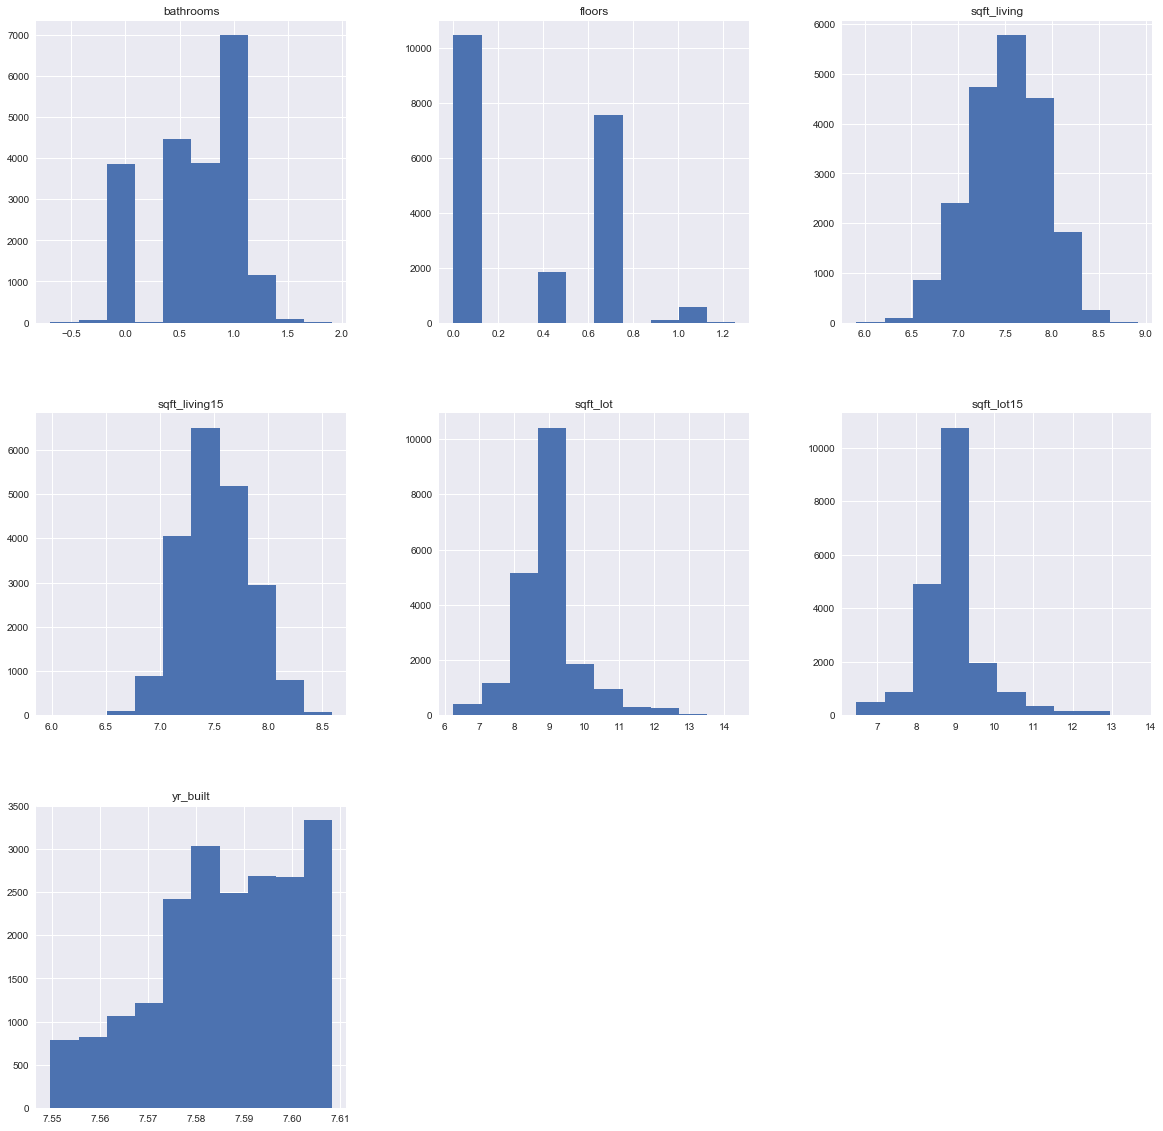

In [16]:
log_variables = ['bathrooms', 'floors', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'yr_built']
df_temp_log = pd.DataFrame([])
for variable in log_variables:
    df_temp_log[variable] = np.log(df_temp[variable])
df_temp_log.hist(figsize=(20,20));

Looks like we were successful for 'bathrooms', 'sqft_living', 'sqft_living15', 'sqft_lot', and 'sqft_lot15'. We'll keep 'floors' and 'yr_built' untransformed since log transforming did not improve the skew.

In [17]:
df_temp_log.drop(['floors','yr_built'], axis=1, inplace=True)

The columns that were transformed still exist in an untransformed state in 'df_temp', so we need to drop those columns from 'df_temp' so our final, concatenated dataframe will make sense.

In [18]:
df_temp.drop(['bathrooms','sqft_living','sqft_living15','sqft_lot','sqft_lot15'], axis=1, inplace=True)

Now we can concatenate 'df_temp' with 'df_temp_log' so we can scale all of them at once.

In [19]:
df_to_scale = pd.concat([df_temp, df_temp_log], axis=1)
df_to_scale.head()

,price,bedrooms,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,is_renovated,bathrooms,sqft_living,sqft_living15,sqft_lot,sqft_lot15
0,221900.0,3,1.0,0,0,3,7,1955,98178,47.5112,-122.257,False,0.000000,7.073270,7.200425,8.639411,8.639411
1,538000.0,3,2.0,0,0,3,7,1951,98125,47.7210,-122.319,True,0.810930,7.851661,7.432484,8.887653,8.941022
2,180000.0,2,1.0,0,0,3,6,1933,98028,47.7379,-122.233,False,0.000000,6.646391,7.908387,9.210340,8.994917
3,604000.0,4,1.0,0,0,5,7,1965,98136,47.5208,-122.393,False,1.098612,7.580700,7.215240,8.517193,8.517193
4,510000.0,3,1.0,0,0,3,8,1987,98074,47.6168,-122.045,False,0.693147,7.426549,7.495542,8.997147,8.923058


Whoops! We forgot to set aside the columns we were saving for one-hot encoding. Let's do that now.

In [20]:
df_to_scale.drop(one_hot_columns, axis=1, inplace=True)
df_to_scale.drop(['price'], axis=1, inplace=True)
df_to_scale.head()

,bedrooms,floors,yr_built,lat,long,bathrooms,sqft_living,sqft_living15,sqft_lot,sqft_lot15
0,3,1.0,1955,47.5112,-122.257,0.000000,7.073270,7.200425,8.639411,8.639411
1,3,2.0,1951,47.7210,-122.319,0.810930,7.851661,7.432484,8.887653,8.941022
2,2,1.0,1933,47.7379,-122.233,0.000000,6.646391,7.908387,9.210340,8.994917
3,4,1.0,1965,47.5208,-122.393,1.098612,7.580700,7.215240,8.517193,8.517193
4,3,1.0,1987,47.6168,-122.045,0.693147,7.426549,7.495542,8.997147,8.923058


Great! Let's try standardizing. We'll use sklearn's MinMaxScaler for now, and we can change it later if it makes sense to do so.

In [22]:
scaled_data = pd.DataFrame([])
for col in df_to_scale.columns:
    scaled_data[col] = (df_to_scale[col] - min(df_to_scale[col])) / (max(df_to_scale[col]) - min(df_to_scale[col]))
scaled_data.head()

,bedrooms,floors,yr_built,lat,long,bathrooms,sqft_living,sqft_living15,sqft_lot,sqft_lot15
0,0.333333,0.0,0.478261,0.571498,0.217608,0.266320,0.385755,0.465682,0.295858,0.300162
1,0.333333,0.4,0.443478,0.908959,0.166113,0.577893,0.644659,0.554885,0.326644,0.342058
2,0.166667,0.0,0.286957,0.936143,0.237542,0.266320,0.243769,0.737820,0.366664,0.349544
3,0.500000,0.0,0.565217,0.586939,0.104651,0.688426,0.554534,0.471377,0.280700,0.283185
4,0.333333,0.0,0.756522,0.741354,0.393688,0.532639,0.503261,0.579124,0.340224,0.339562


### One-hot encoding

We'll be doing this part by hand, just to keep in touch with what's going on under the hood. Let's remind ourselves of the variables we set aside for encoding.

In [24]:
one_hot_columns

['waterfront', 'view', 'condition', 'grade', 'is_renovated', 'zipcode']

In [25]:
waterfront_dummies = pd.get_dummies(df_temp['waterfront'], prefix='wat', drop_first=True)
view_dummies = pd.get_dummies(df_temp['view'], prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(df_temp['condition'], prefix='con', drop_first=True)
grade_dummies = pd.get_dummies(df_temp['grade'], prefix='grad', drop_first=True)
is_renovated_dummies = pd.get_dummies(df_temp['is_renovated'], prefix='ren', drop_first=True)
zipcode_dummies = pd.get_dummies(df_temp['zipcode'], prefix='zip', drop_first=True)

Now that we've got our continuous variables standardized, and our categorical dummies encoded, let's concatenate everything with our 'price' column.

In [26]:
data = pd.concat([df_temp['price'], scaled_data, waterfront_dummies, view_dummies, condition_dummies, grade_dummies, 
                  is_renovated_dummies, zipcode_dummies], axis=1)

data.head()

,price,bedrooms,floors,yr_built,lat,long,bathrooms,sqft_living,sqft_living15,sqft_lot,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,221900.0,0.333333,0.0,0.478261,0.571498,0.217608,0.266320,0.385755,0.465682,0.295858,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,0.333333,0.4,0.443478,0.908959,0.166113,0.577893,0.644659,0.554885,0.326644,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,0.166667,0.0,0.286957,0.936143,0.237542,0.266320,0.243769,0.737820,0.366664,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,0.500000,0.0,0.565217,0.586939,0.104651,0.688426,0.554534,0.471377,0.280700,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,0.333333,0.0,0.756522,0.741354,0.393688,0.532639,0.503261,0.579124,0.340224,...,0,0,0,0,0,0,0,0,0,0


Whew! That's a lot of work just to get the data into a form that will make linear regression possible. 

### Preliminary model

Let's create a preliminary model using OLS and every single column we've got. This will obviously sacrifice lots of interpretability for accuracy, but we just want a benchmark for how high our R-squared value is, just to ensure that we don't lose too much accuracy after whittling the list down to 4-7 features.

In [27]:
data.columns

Index(['price', 'bedrooms', 'floors', 'yr_built', 'lat', 'long', 'bathrooms',
       'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'wat_1',
       'view_1', 'view_2', 'view_3', 'view_4', 'con_2', 'con_3', 'con_4',
       'con_5', 'grad_4', 'grad_5', 'grad_6', 'grad_7', 'grad_8', 'grad_9',
       'grad_10', 'grad_11', 'grad_12', 'ren_True', 'zip_98002', 'zip_98003',
       'zip_98004', 'zip_98005', 'zip_98006', 'zip_98007', 'zip_98008',
       'zip_98010', 'zip_98011', 'zip_98014', 'zip_98019', 'zip_98022',
       'zip_98023', 'zip_98024', 'zip_98027', 'zip_98028', 'zip_98029',
       'zip_98030', 'zip_98031', 'zip_98032', 'zip_98033', 'zip_98034',
       'zip_98038', 'zip_98039', 'zip_98040', 'zip_98042', 'zip_98045',
       'zip_98052', 'zip_98053', 'zip_98055', 'zip_98056', 'zip_98058',
       'zip_98059', 'zip_98065', 'zip_98070', 'zip_98072', 'zip_98074',
       'zip_98075', 'zip_98077', 'zip_98092', 'zip_98102', 'zip_98103',
       'zip_98105', 'zip_98106', 'zip_98107'

In [28]:
from statsmodels.formula.api import ols

outcome = 'price'
x_cols = data.drop(['price'], axis=1)
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1050.
Date:                Sun, 27 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:50:27   Log-Likelihood:            -2.6246e+05
No. Observations:               20525   AIC:                         5.251e+05
Df Residuals:                   20426   BIC:                         5.259e+05
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.088e+05   8.92e+04     -1.220      0.222   -2.84e+05     6.6e+04
bedrooms      -1.326e+04   5683.788     -2.333      0.020   -2.44e+04   -2118.221
floors         1.914e+04   4048.738      4.727      0.000    1.12e+04    2.71e+04
yr_built      -2.605e+04   4377.980     -5.951      0.000   -3.46e+04   -1.75e+04
lat            8.875e+04   2.18e+04      4.074      0.000    4.61e+04    1.31e+05
long          -1.238e+05   3.04e+04     -4.070      0.000   -1.83e+05   -6.42e+04
bathrooms      3.201e+04   7446.118      4.299      0.000    1.74e+04    4.66e+04
sqft_living    5.088e+05   1.02e+04     49.677      0.000    4.89e+05    5.29e+05
sqft_living15  1.609e+05   8753.813     18.379      0.000    1.44e+05    1.78e+05
sqft_lot        2.85e+05   1.45e+04     19.600      0.000    2.56e+05    3.13e+05
sqft_lot15    -8.697e+04   1.43e+04     -6.084      0.000   -1.15e+05   -5.89e+04
wat_1          1.539e+05   1.35e+04     11.357      0.000    1.27e+05     1.8e+05
view_1         5.506e+04   5349.411     10.293      0.000    4.46e+04    6.55e+04
view_2         5.277e+04   3229.439     16.339      0.000    4.64e+04    5.91e+04
view_3         8.443e+04   4799.489     17.592      0.000     7.5e+04    9.38e+04
view_4         1.583e+05   7936.572     19.945      0.000    1.43e+05    1.74e+05
con_2          7.533e+04   1.78e+04      4.224      0.000    4.04e+04     1.1e+05
con_3          1.085e+05   1.66e+04      6.524      0.000    7.59e+04    1.41e+05
con_4          1.253e+05   1.66e+04      7.527      0.000    9.27e+04    1.58e+05
con_5          1.605e+05   1.68e+04      9.583      0.000    1.28e+05    1.93e+05
grad_4        -1.344e+05   8.86e+04     -1.517      0.129   -3.08e+05    3.93e+04
grad_5        -1.765e+05   8.72e+04     -2.025      0.043   -3.47e+05   -5643.304
grad_6        -1.854e+05    8.7e+04     -2.131      0.033   -3.56e+05   -1.48e+04
grad_7        -1.767e+05    8.7e+04     -2.030      0.042   -3.47e+05   -6115.625
grad_8        -1.348e+05   8.71e+04     -1.548      0.122   -3.05e+05    3.59e+04
grad_9        -4.484e+04   8.71e+04     -0.515      0.607   -2.16e+05    1.26e+05
grad_10         2.47e+04   8.72e+04      0.283      0.777   -1.46e+05    1.96e+05
grad_11        1.338e+05   8.74e+04      1.531      0.126   -3.75e+04    3.05e+05
grad_12        9.379e+04   9.55e+04      0.983      0.326   -9.33e+04    2.81e+05
ren_True       4.137e+04   3732.598     11.084      0.000    3.41e+04    4.87e+04
zip_98002      2.396e+04   7849.210      3.052      0.002    8570.417    3.93e+04
zip_98003     -2620.9396   6994.433     -0.375      0.708   -1.63e+04    1.11e+04
zip_98004       4.83e+05   1.37e+04     35.337      0.000    4.56e+05     5.1e+05
zip_98005       2.98e+05   1.38e+04     21.532      0.000    2.71e+05    3.25e+05
zip_98006      2.511e+05   1.14e+04     22.032   

Using every column, we get an adjusted R-squared of 0.834. Not bad! But this model is nigh impossible to understand with nearly one hundred columns, so let's whittle it down a bit to boost some interpretability. We'll use stepwise selection for this.

### Feature selection

In [29]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [30]:
result = stepwise_selection(x_cols, data['price'], verbose=True)
print('resulting features:')
print(result)

C:\Users\Devin\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  grad_9                         with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  grad_10                        with p-value 0.0
Add  lat                            with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  grad_8                         with p-value 9.00508e-192
Add  grad_11                        with p-value 9.39216e-278
Add  zip_98004                      with p-value 3.19378e-212
Add  zip_98040                      with p-value 2.10297e-132
Add  zip_98155                      with p-value 9.96819e-130
Add  zip_98133                      with p-value 9.64517e-118
Add  zip_98028                      with p-value 2.67356e-115
Add  view_4                         with p-value 7.52494e-96
Add  zip_98019                      with p-value 5.87913e-95
Add  zip_98011                      with p-value 6.18868e-98
Add  zip_980

C:\Users\Devin\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  zip_98007                      with p-value 0.00030695
Drop zip_98010                      with p-value 0.225221
Add  zip_98008                      with p-value 0.00254517
Drop zip_98166                      with p-value 0.296868
Add  zip_98075                      with p-value 2.55459e-05
Drop zip_98052                      with p-value 0.783643
Add  zip_98027                      with p-value 1.31907e-09
Drop zip_98053                      with p-value 0.944589
Add  zip_98010                      with p-value 7.38572e-05
Drop zip_98074                      with p-value 0.989526
Add  zip_98118                      with p-value 0.00487929
Drop long                           with p-value 0.440621
Add  zip_98052                      with p-value 0.00028664
Drop zip_98065                      with p-value 0.173543
Add  zip_98053                      with p-value 9.38893e-05
Drop zip_98045                      with p-value 0.301044
Add  zip_98074                      with p-value 2.3

Apparently our stepwise selection function deemed a long list of features suitable for linear regression. 

In [31]:
len(result)

87

87 columns is barely fewer than what we started with, let's see if it made a big difference in our adjusted R-squared.

In [32]:
outcome = 'price'
cols = result
predictors = '+'.join(cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1175.
Date:                Sun, 27 Oct 2019   Prob (F-statistic):               0.00
Time:                        17:00:53   Log-Likelihood:            -2.6252e+05
No. Observations:               20525   AIC:                         5.252e+05
Df Residuals:                   20437   BIC:                         5.259e+05
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.297e+05    1.8e+04    -18.344      0.000   -3.65e+05   -2.94e+05
grad_9         1.326e+05   2653.093     49.964      0.000    1.27e+05    1.38e+05
bathrooms       3.09e+04   7393.299      4.180      0.000    1.64e+04    4.54e+04
grad_10        2.028e+05   3951.024     51.340      0.000    1.95e+05    2.11e+05
lat             2.57e+05   6963.158     36.904      0.000    2.43e+05    2.71e+05
sqft_living15  1.633e+05   8711.041     18.750      0.000    1.46e+05     1.8e+05
yr_built      -2.772e+04   4267.101     -6.496      0.000   -3.61e+04   -1.94e+04
sqft_living    4.961e+05   9107.914     54.465      0.000    4.78e+05    5.14e+05
grad_8         4.231e+04   1748.761     24.197      0.000    3.89e+04    4.57e+04
grad_11        3.111e+05   7476.063     41.614      0.000    2.96e+05    3.26e+05
zip_98004      3.748e+05   7324.903     51.161      0.000     3.6e+05    3.89e+05
zip_98040       2.94e+05   7099.432     41.408      0.000     2.8e+05    3.08e+05
zip_98155     -5.686e+04   5510.857    -10.318      0.000   -6.77e+04   -4.61e+04
zip_98133      -3.11e+04   5231.774     -5.944      0.000   -4.14e+04   -2.08e+04
zip_98028     -6.448e+04   6321.977    -10.200      0.000   -7.69e+04   -5.21e+04
view_4         1.592e+05   7953.311     20.020      0.000    1.44e+05    1.75e+05
zip_98019     -9.308e+04   7283.959    -12.779      0.000   -1.07e+05   -7.88e+04
zip_98011      -5.47e+04   7217.402     -7.579      0.000   -6.88e+04   -4.06e+04
zip_98072     -2.852e+04   6495.410     -4.390      0.000   -4.12e+04   -1.58e+04
zip_98125      1.951e+04   5446.452      3.581      0.000    8830.908    3.02e+04
zip_98077     -3.037e+04   7466.853     -4.067      0.000    -4.5e+04   -1.57e+04
zip_98022      2.636e+04   6745.248      3.908      0.000    1.31e+04    3.96e+04
zip_98177      2.484e+04   6735.489      3.688      0.000    1.16e+04     3.8e+04
zip_98112      2.968e+05   7271.922     40.813      0.000    2.83e+05    3.11e+05
zip_98014     -6.682e+04   8601.389     -7.768      0.000   -8.37e+04      -5e+04
zip_98168     -4.629e+04   5700.648     -8.121      0.000   -5.75e+04   -3.51e+04
view_3          8.53e+04   4805.515     17.750      0.000    7.59e+04    9.47e+04
view_2         5.325e+04   3234.043     16.465      0.000    4.69e+04    5.96e+04
zip_98178     -4.063e+04   5774.027     -7.037      0.000   -5.19e+04   -2.93e+04
zip_98006      1.519e+05   4841.754     31.369      0.000    1.42e+05    1.61e+05
con_5          1.604e+05   1.67e+04      9.616      0.000    1.28e+05    1.93e+05
zip_98119      2.627e+05   7669.012     34.250      0.000    2.48e+05    2.78e+05
zip_98116      1.789e+05   5513.282     32.440      0.000    1.68e+05     1.9e+05
sqft_lot        2.82e+05   1.45e+04     19.385      0.000    2.54e+05    3.11e+05
zip_98109      2.806e+05   9791.280     28.656   

As we suspected, not much change in our adjusted R-squared. There are clearly too many features to interpret the model in any meaningful way, so let's run Regressive Feature Elimination instead.

### Feature Selection with RFE

In [33]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=1)
selector = selector.fit(x_cols.drop(['lat','long'], axis=1), data['price'])
selector.ranking_

array([89, 88, 86, 85,  1,  3, 29, 63, 24, 73, 74, 58, 12, 68, 67, 66, 65,
       59, 43, 42, 41, 44, 69, 84, 11, 71, 75, 90, 95,  4, 19, 22, 25, 31,
       70, 50, 64, 62, 94, 82, 53, 37, 52, 30, 93, 92, 96, 20, 38, 79,  2,
        6, 91, 60, 28, 32, 77, 56, 80, 57, 51, 61, 45, 33, 27, 46, 83,  8,
       14, 10, 48, 15, 49,  7,  5, 18, 21, 16, 39,  9, 17, 36, 34, 40, 23,
       26, 54, 72, 47, 55, 78, 35, 76, 81, 87, 13])

In [34]:
import operator

rankings = list(zip(selector.ranking_,x_cols.drop(['lat','long'],axis=1).columns))
rankings.sort(key=operator.itemgetter(0))
rankings

[(1, 'sqft_living'),
 (2, 'zip_98039'),
 (3, 'sqft_living15'),
 (4, 'zip_98004'),
 (5, 'zip_98112'),
 (6, 'zip_98040'),
 (7, 'zip_98109'),
 (8, 'zip_98102'),
 (9, 'zip_98119'),
 (10, 'zip_98105'),
 (11, 'grad_11'),
 (12, 'view_4'),
 (13, 'zip_98199'),
 (14, 'zip_98103'),
 (15, 'zip_98107'),
 (16, 'zip_98117'),
 (17, 'zip_98122'),
 (18, 'zip_98115'),
 (19, 'zip_98005'),
 (20, 'zip_98033'),
 (21, 'zip_98116'),
 (22, 'zip_98006'),
 (23, 'zip_98136'),
 (24, 'wat_1'),
 (25, 'zip_98007'),
 (26, 'zip_98144'),
 (27, 'zip_98075'),
 (28, 'zip_98052'),
 (29, 'sqft_lot'),
 (30, 'zip_98029'),
 (31, 'zip_98008'),
 (32, 'zip_98053'),
 (33, 'zip_98074'),
 (34, 'zip_98126'),
 (35, 'zip_98177'),
 (36, 'zip_98125'),
 (37, 'zip_98027'),
 (38, 'zip_98034'),
 (39, 'zip_98118'),
 (40, 'zip_98133'),
 (41, 'grad_7'),
 (42, 'grad_6'),
 (43, 'grad_5'),
 (44, 'grad_8'),
 (45, 'zip_98072'),
 (46, 'zip_98077'),
 (47, 'zip_98155'),
 (48, 'zip_98106'),
 (49, 'zip_98108'),
 (50, 'zip_98011'),
 (51, 'zip_98065'),
 (52,

At this point, we have a decision to make. The more ZIP codes we choose to include in our model (i.e. the more of our ranked list we choose to tap), the more non-ZIP columns we'll have to use. We need to pick the amount of the list that will give us a robust model while still keeping the amount of information digestible. 

In [35]:
columns_final = [rank[1] for rank in rankings[:23]]
columns_final

['sqft_living',
 'zip_98039',
 'sqft_living15',
 'zip_98004',
 'zip_98112',
 'zip_98040',
 'zip_98109',
 'zip_98102',
 'zip_98119',
 'zip_98105',
 'grad_11',
 'view_4',
 'zip_98199',
 'zip_98103',
 'zip_98107',
 'zip_98117',
 'zip_98122',
 'zip_98115',
 'zip_98005',
 'zip_98033',
 'zip_98116',
 'zip_98006',
 'zip_98136']

It might seem intuitive that, to help get an increase of the selling price, we would want to generate interest in the property, but our model only gives a result for a home getting 4 views or more. This is not necessarily interpretable, and so we will omit it from our model.

In [36]:
columns_final.remove('view_4')

### OLS

As was our goal, this set of 4 unique features will keep the interpretability high. Let's rerun OLS and see how accurate the model is.

In [37]:
outcome = 'price'
predictors = '+'.join(columns_final)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     1628.
Date:                Sun, 27 Oct 2019   Prob (F-statistic):               0.00
Time:                        17:11:24   Log-Likelihood:            -2.7054e+05
No. Observations:               20525   AIC:                         5.411e+05
Df Residuals:                   20502   BIC:                         5.413e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.136e+05   4847.676    -44.069      0.000   -2.23e+05   -2.04e+05
sqft_living    7.179e+05   9857.730     72.824      0.000    6.99e+05    7.37e+05
zip_98039      5.047e+05   4.85e+04     10.397      0.000     4.1e+05       6e+05
sqft_living15  4.301e+05   1.12e+04     38.407      0.000    4.08e+05    4.52e+05
zip_98004      3.826e+05   1.02e+04     37.391      0.000    3.62e+05    4.03e+05
zip_98112      3.279e+05   9785.629     33.505      0.000    3.09e+05    3.47e+05
zip_98040      3.104e+05   9951.033     31.193      0.000    2.91e+05     3.3e+05
zip_98109      3.199e+05   1.37e+04     23.308      0.000    2.93e+05    3.47e+05
zip_98102      3.095e+05   1.38e+04     22.421      0.000    2.82e+05    3.37e+05
zip_98119      3.087e+05   1.04e+04     29.784      0.000    2.88e+05    3.29e+05
zip_98105      2.722e+05   9706.356     28.042      0.000    2.53e+05    2.91e+05
grad_11        2.239e+05   1.04e+04     21.553      0.000    2.04e+05    2.44e+05
zip_98199      2.575e+05   7809.587     32.970      0.000    2.42e+05    2.73e+05
zip_98103       2.27e+05   5428.929     41.818      0.000    2.16e+05    2.38e+05
zip_98107      2.238e+05   8039.539     27.835      0.000    2.08e+05     2.4e+05
zip_98117      2.183e+05   5643.891     38.684      0.000    2.07e+05    2.29e+05
zip_98122      2.125e+05   7877.478     26.974      0.000    1.97e+05    2.28e+05
zip_98115      2.123e+05   5531.298     38.374      0.000    2.01e+05    2.23e+05
zip_98005      2.139e+05   1.04e+04     20.587      0.000    1.94e+05    2.34e+05
zip_98033      2.102e+05   6706.280     31.351      0.000    1.97e+05    2.23e+05
zip_98116      2.047e+05   7342.642     27.885      0.000     1.9e+05    2.19e+05
zip_98006      1.682e+05   6443.736     26.101      0.000    1.56e+05    1.81e+05
zip_98136      1.694e+05   8071.158     20.990      0.000    1.54e+05    1.85e+05
==============================================================================
Omnibus:                      858.664   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1039.285
Skew:                           0.469   Prob(JB):                    2.10e-226
Kurtosis:                       3.580   Cond. No.                         69.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our adjusted R-squared is an acceptably high 0.636, so we will deem this model sufficient for now.

### Model Validation

At this point, we have a model, and we should use it to execute our train-test split and our K-fold cross validation experiments. 

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[columns_final], data['price'], test_size=0.2)
print(len(X_train), len(X_test), len(y_train), len(y_test))

16420 4105 16420 4105


In [39]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [40]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [41]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squared Error:', mse_train)
print('Test Mean Squared Error:', mse_test)
print('Train RMSE:', np.sqrt(mse_train))
print('Test RMSE:', np.sqrt(mse_test))

Train Mean Squared Error: 16320858255.084064
Test Mean Squared Error: 17020743464.842318
Train RMSE: 127753.11446334318
Test RMSE: 130463.57140919575


In [42]:
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, data[columns_final], data['price'], cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, data[columns_final], data['price'], cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, data[columns_final], data['price'], cv=20, scoring='neg_mean_squared_error'))

In [43]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-16530896727.259258
-16525446400.65944
-16506593534.20802


# Conclusion

As we have seen from our model, 63% of the price of a house can be predicted from just four features: ZIP code, King County housing grade, size of living space, and size of living space of the nearest 15 neighboring properties. Specifically, the model recommends:

* Buying in certain ZIP codes over others
* Increasing the King County housing grade to at least 11
* Increasing the size of the living space
* Buying houses that are surrounded by other large houses

### Extra: Creating Visualizations of Features

This is an extra section wherein the raw code for the graphs in the non-technical presentation is housed.

In [44]:
df_graph = df.copy()
df_graph['view'].fillna(0., inplace=True)
df_graph['view'] = df_graph['view'].astype(int)
df_graph = df_graph[df_graph['price'] <= 1170000]
df_graph = df_graph[df_graph['bedrooms'] < 8].reset_index()
df_graph.drop(['index'], axis=1, inplace=True)
print(len(df_graph)/len(df))
df_graph.columns

0.9503634764087605


Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [45]:
df_graph.drop(['id','date','bedrooms','bathrooms','sqft_lot','floors','waterfront','condition','sqft_above',
               'sqft_basement','yr_built','yr_renovated','lat','long','sqft_lot15'], axis=1, inplace=True)
df_graph.head()

,price,sqft_living,view,grade,zipcode,sqft_living15
0,221900.0,1180,0,7,98178,1340
1,538000.0,2570,0,7,98125,1690
2,180000.0,770,0,6,98028,2720
3,604000.0,1960,0,7,98136,1360
4,510000.0,1680,0,8,98074,1800


Text(0.5, 1.0, 'Zipcode')

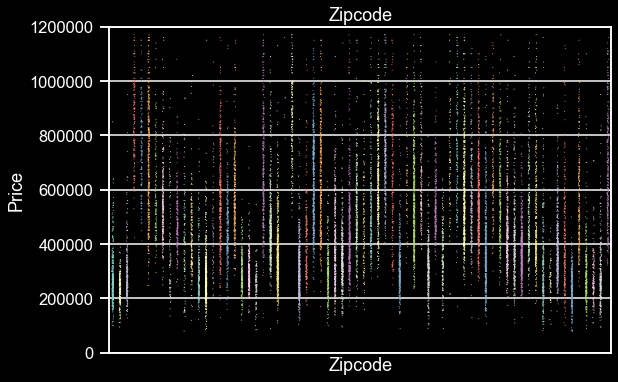

In [46]:
plt.style.use('dark_background')

sns.set_context('talk')
f, ax = plt.subplots(figsize=(9,6))
ax = sns.stripplot(x=df_graph['zipcode'], y=df_graph['price'], size=1, palette='Set3')
ax.set_xlabel('Zipcode', fontname='Arial')
ax.set_xticks([])
ax.set_ylim(0,1200000)
ax.set_ylabel('Price', fontname='Arial')
ax.set_title('Zipcode', fontname='Arial')

This graph is unreadable to the point of meaninglessness. We will omit it from the final presentation.

Text(0.5, 1.0, 'Living Space')

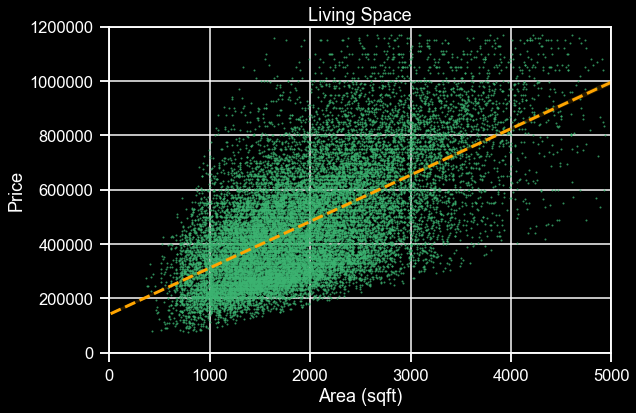

In [48]:
f, ax = plt.subplots(figsize=(9,6))
ax = sns.regplot(x='sqft_living', y='price', data=df_graph, color='mediumseagreen', scatter_kws={'s':4}, 
            line_kws={'linewidth':3,'linestyle':'dashed','color':'orange'})
ax.set_xlim(0,5000)
ax.set_ylim(0,1200000)
ax.set_xlabel('Area (sqft)', fontname='Arial')
ax.set_ylabel('Price', fontname='Arial')
ax.set_title('Living Space', fontname='Arial')

Text(0.5, 1.0, 'Housing Grade')

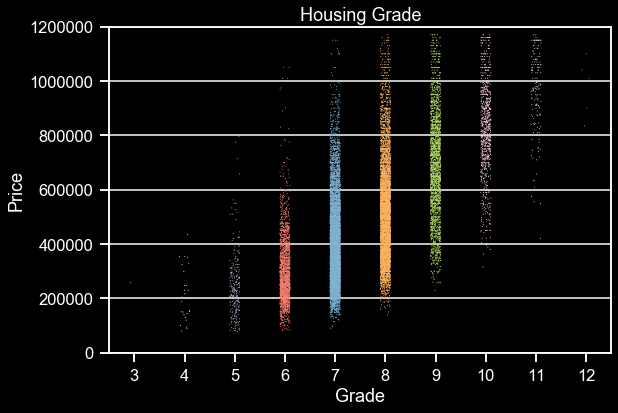

In [49]:
f, ax = plt.subplots(figsize=(9,6))
ax = sns.stripplot(x=df_graph['grade'], y=df_graph['price'], size=1, palette='Set3')
ax.set_ylim(0,1200000)
ax.set_xlabel('Grade', fontname='Arial')
ax.set_ylabel('Price', fontname='Arial')
ax.set_title('Housing Grade', fontname='Arial')


Text(0.5, 1.0, "Neighbor's Living Space")

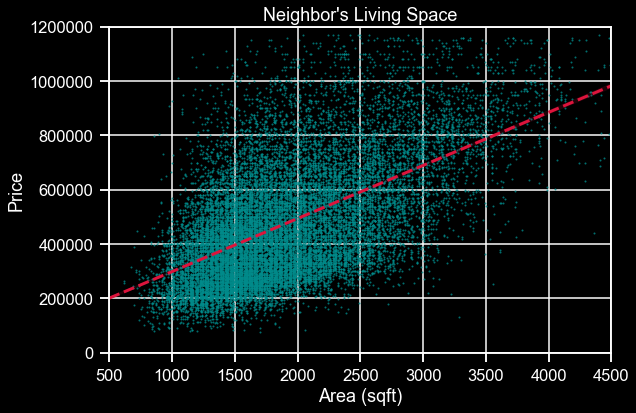

In [50]:
f, ax = plt.subplots(figsize=(9,6))
ax = sns.regplot(x='sqft_living15', y='price', data=df_graph, color='darkcyan', scatter_kws={'s':4}, 
            line_kws={'linewidth':3,'linestyle':'dashed','color':'crimson'})
ax.set_xlim(500,4500)
ax.set_ylim(0,1200000)
ax.set_xlabel('Area (sqft)', fontname='Arial')
ax.set_ylabel('Price', fontname='Arial')
ax.set_title('''Neighbor's Living Space''', fontname='Arial')